**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import Dataset
import albumentations as A


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):    
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1].astype(np.uint8)  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
        
        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }
        

        sample['image'] = self.transform(sample['image']).float()
        sample['mask'] = self.transform(sample['mask'] > 0).float()

        return sample

In [3]:
X_train = get_paths("data/train/images")
y_train = get_paths("data/train/gt")


transform = transforms.Compose([
    transforms.ToTensor(),
])


aug = A.Compose([
    A.PadIfNeeded(512, 512),
    # A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=1.0),
    
    ], additional_targets={'mask': 'image'}
)

In [4]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]
    return images

In [5]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / (union + 1e-5)

In [6]:
train_dataset = RoadDataset(X_train, y_train, transform, aug)

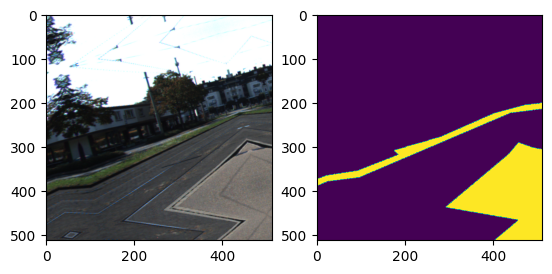

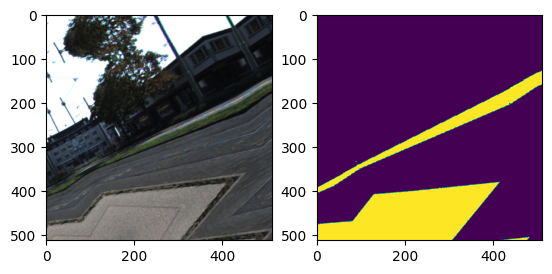

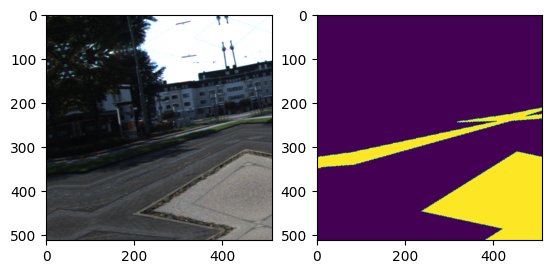

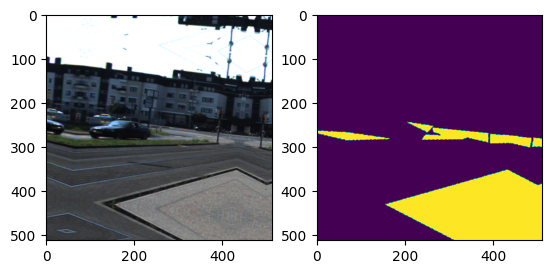

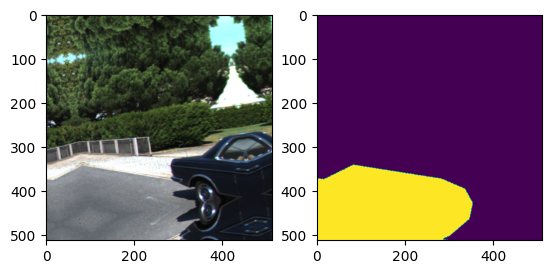

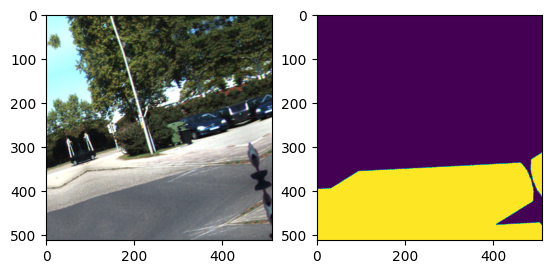

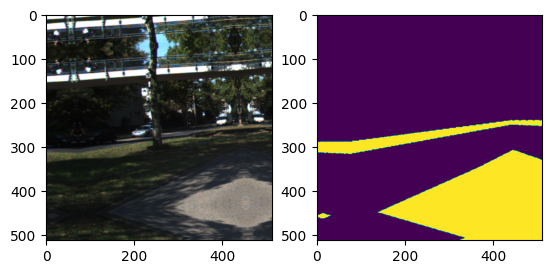

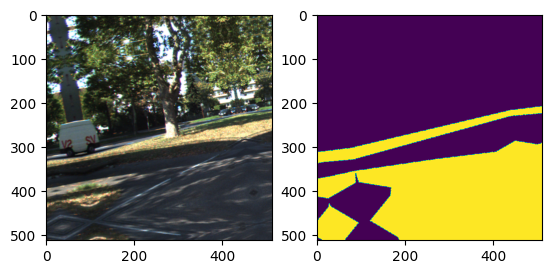

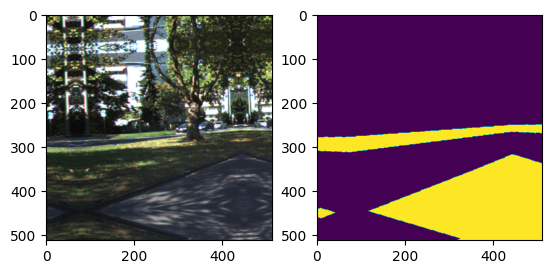

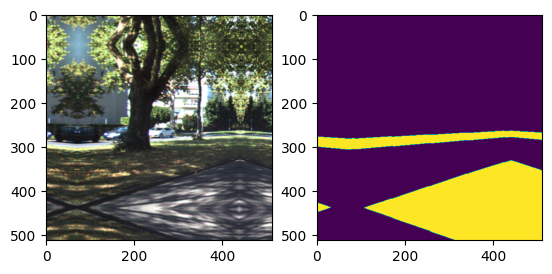

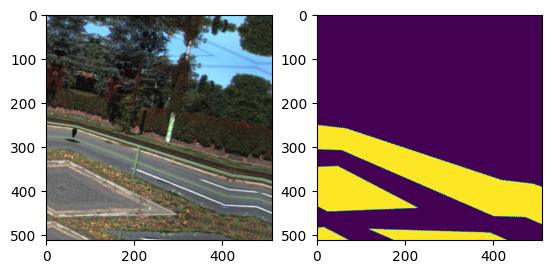

In [7]:
for i in range(11):
    sample = train_dataset[i] #110
    image = sample['image']
    mask = sample['mask']

    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(mask.permute(1, 2, 0))
    plt.pause(1)
    

In [8]:
from tqdm import tqdm

positive = 0
total = 0
for dat in tqdm(RoadDataset(X_train, y_train, transform, aug)):
    positive += dat['mask'].sum()
    total += dat['mask'].shape[0] * dat['mask'].shape[1] * dat['mask'].shape[2]
    
print(positive / total)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:43<00:00, 14.87it/s]

tensor(0.2310)


Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [9]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down5 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32 // factor, bilinear)
        self.up5 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        
        self.apply(self.weight_init)
        
    @staticmethod
    def weight_init(m):
        if isinstance(m, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            nn.init.xavier_normal_(m.weight)
            if getattr(m, 'bias') is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x = self.up1(x6, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)
        logits = self.outc(x)
        return logits

In [16]:
from tqdm import tqdm
from torch.utils.data import DataLoader


X_test = get_paths("data/test/images")
y_test = get_paths("data/test/gt")

augeval = A.Compose([
    A.PadIfNeeded(512, 512),
    ], additional_targets={'mask': 'image'}
)


def test(model, thr, mode):
    if mode == 'train':
        xdat, ydat = X_train, y_train
    else:
        xdat, ydat = X_test, y_test
    vals = []
    for dat in DataLoader(RoadDataset(xdat, ydat, transform, augeval), batch_size=1, num_workers=1):
        x = dat['image']
        y = central_crop(dat['mask'], 370).numpy()
        logits = F.adaptive_max_pool2d(model(torch.tensor(x).to(device)).cpu(), output_size=(370,370))[0]
        pred = (F.sigmoid(logits) > thr).numpy()
        vals.append(calc_iou(pred, y))
    return np.mean(vals)

In [12]:
UNet(n_channels=3, n_classes=1).to('cuda:0')(torch.rand((16, 3, 256, 256)).to('cuda:0'))

/home/dsorokin/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[[[ 0.2466, -0.1860, -0.1269,  ...,  0.1129,  0.0220, -0.5696],
          [-0.0027, -0.9130, -0.1359,  ..., -0.1570,  0.0729, -0.0825],
          [ 0.2546, -0.4687, -0.0824,  ..., -0.4966,  0.4350,  0.0233],
          ...,
          [ 0.8124,  0.3849, -0.2576,  ...,  0.1131, -0.6820,  0.1073],
          [-0.6468, -0.3039,  0.2428,  ...,  0.1373, -0.0597,  0.0658],
          [-0.4437, -0.1987, -0.1901,  ..., -0.6310, -0.3422, -0.5994]]],


        [[[ 0.1849, -0.3484,  0.7835,  ...,  0.4985, -0.0192, -0.3087],
          [ 0.1464, -0.5643,  0.0551,  ...,  0.2887, -0.0288, -0.1137],
          [ 0.6879,  0.2253, -0.4252,  ...,  0.5039,  0.0348, -0.3857],
          ...,
          [-0.7397, -0.8302, -0.6490,  ..., -0.3452, -0.3058, -0.7221],
          [-0.8952, -0.4008, -0.3673,  ...,  0.0878, -0.1453, -0.3217],
          [ 0.0250, -0.7564,  0.0814,  ..., -0.0946,  0.4739, -0.3101]]],


        [[[-0.1604,  0.3507,  0.2042,  ..., -0.1313, -0.1577, -0.2100],
          [-0.3724, -0.224

Good luck!

In [14]:
from torch.optim import Adam
from tqdm import trange   
from torch.utils.data import DataLoader


device = 'cuda:0'
model = UNet(n_channels=3, n_classes=1).to(device).train()
opt = Adam(model.parameters())
tot = len(X_train)
losses = []
ious = []

for iepoch in trange(300):
    for g in opt.param_groups:
        g['lr'] = 0.001 * (1 - iepoch / 300)
    
    epoch_loss = []
    for item in DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1):
        x = item['image'].to(device)
        y = item['mask'].to(device)
        batch_size = x.shape[0]
        
        logits = F.adaptive_max_pool2d(model(x), output_size=(370, 370)).reshape(batch_size, -1)
        y = central_crop(y, 370).reshape(batch_size, -1)
        #logits = model(x).view(batch_size, -1)
        #y = y.view(batch_size, -1)
        
        opt.zero_grad()
        loss = F.binary_cross_entropy_with_logits(
            logits,
            y,
            pos_weight=torch.tensor(5),
        )

        
        loss.backward()
        opt.step()
        epoch_loss.append(loss.detach().cpu().numpy())
    losses.append(np.mean(epoch_loss))
    # ious.append(test(model))
    torch.save(model.state_dict(), f'checkpoint_{iepoch}.pt')
    print(losses[-1])


  0%|▍                                                                                                                                   | 1/300 [00:09<45:40,  9.17s/it]

0.8576518


  1%|▉                                                                                                                                   | 2/300 [00:18<45:50,  9.23s/it]

0.6393507


  1%|█▎                                                                                                                                  | 3/300 [00:27<45:42,  9.23s/it]

0.5685525


  1%|█▊                                                                                                                                  | 4/300 [00:37<45:46,  9.28s/it]

0.54157513


  2%|██▏                                                                                                                                 | 5/300 [00:46<46:28,  9.45s/it]

0.49169576


  2%|██▋                                                                                                                                 | 6/300 [00:56<46:11,  9.43s/it]

0.5016528


  2%|███                                                                                                                                 | 7/300 [01:05<46:08,  9.45s/it]

0.45030826


  3%|███▌                                                                                                                                | 8/300 [01:15<45:59,  9.45s/it]

0.4301849


  3%|███▉                                                                                                                                | 9/300 [01:24<46:20,  9.55s/it]

0.42039838


  3%|████▎                                                                                                                              | 10/300 [01:34<46:13,  9.57s/it]

0.389373


  4%|████▊                                                                                                                              | 11/300 [01:43<45:56,  9.54s/it]

0.41091746


  4%|█████▏                                                                                                                             | 12/300 [01:53<45:31,  9.48s/it]

0.37517613


  4%|█████▋                                                                                                                             | 13/300 [02:02<45:13,  9.46s/it]

0.38666552


  5%|██████                                                                                                                             | 14/300 [02:12<45:02,  9.45s/it]

0.3575658


  5%|██████▌                                                                                                                            | 15/300 [02:21<44:52,  9.45s/it]

0.3478358


  5%|██████▉                                                                                                                            | 16/300 [02:30<44:39,  9.43s/it]

0.3348381


  6%|███████▍                                                                                                                           | 17/300 [02:40<44:29,  9.43s/it]

0.33698714


  6%|███████▊                                                                                                                           | 18/300 [02:49<44:31,  9.47s/it]

0.32972303


  6%|████████▎                                                                                                                          | 19/300 [02:59<44:33,  9.52s/it]

0.3128797


  7%|████████▋                                                                                                                          | 20/300 [03:09<44:19,  9.50s/it]

0.32260567


  7%|█████████▏                                                                                                                         | 21/300 [03:18<44:18,  9.53s/it]

0.3086082


  7%|█████████▌                                                                                                                         | 22/300 [03:28<44:05,  9.52s/it]

0.30946153


  8%|██████████                                                                                                                         | 23/300 [03:37<43:42,  9.47s/it]

0.29485324


  8%|██████████▍                                                                                                                        | 24/300 [03:46<43:22,  9.43s/it]

0.26825348


  8%|██████████▉                                                                                                                        | 25/300 [03:56<43:09,  9.42s/it]

0.29118004


  9%|███████████▎                                                                                                                       | 26/300 [04:05<43:03,  9.43s/it]

0.2823437


  9%|███████████▊                                                                                                                       | 27/300 [04:15<43:07,  9.48s/it]

0.28991324


  9%|████████████▏                                                                                                                      | 28/300 [04:24<42:58,  9.48s/it]

0.3245271


 10%|████████████▋                                                                                                                      | 29/300 [04:34<42:58,  9.51s/it]

0.300846


 10%|█████████████                                                                                                                      | 30/300 [04:43<42:45,  9.50s/it]

0.29122078


 10%|█████████████▌                                                                                                                     | 31/300 [04:53<42:21,  9.45s/it]

0.25595513


 11%|█████████████▉                                                                                                                     | 32/300 [05:02<42:07,  9.43s/it]

0.25754687


 11%|██████████████▍                                                                                                                    | 33/300 [05:11<41:59,  9.44s/it]

0.25190592


 11%|██████████████▊                                                                                                                    | 34/300 [05:21<41:44,  9.42s/it]

0.24359192


 12%|███████████████▎                                                                                                                   | 35/300 [05:30<41:31,  9.40s/it]

0.25226468


 12%|███████████████▋                                                                                                                   | 36/300 [05:40<41:15,  9.38s/it]

0.2363373


 12%|████████████████▏                                                                                                                  | 37/300 [05:49<41:06,  9.38s/it]

0.22794302


 13%|████████████████▌                                                                                                                  | 38/300 [05:58<40:51,  9.36s/it]

0.24831472


 13%|█████████████████                                                                                                                  | 39/300 [06:08<40:37,  9.34s/it]

0.22681136


 13%|█████████████████▍                                                                                                                 | 40/300 [06:17<40:20,  9.31s/it]

0.22079636


 14%|█████████████████▉                                                                                                                 | 41/300 [06:26<40:03,  9.28s/it]

0.20848244


 14%|██████████████████▎                                                                                                                | 42/300 [06:35<39:50,  9.26s/it]

0.22065505


 14%|██████████████████▊                                                                                                                | 43/300 [06:45<39:52,  9.31s/it]

0.20538804


 15%|███████████████████▏                                                                                                               | 44/300 [06:54<39:52,  9.35s/it]

0.20567444


 15%|███████████████████▋                                                                                                               | 45/300 [07:03<39:44,  9.35s/it]

0.21052162


 15%|████████████████████                                                                                                               | 46/300 [07:13<39:30,  9.33s/it]

0.23237507


 16%|████████████████████▌                                                                                                              | 47/300 [07:22<39:25,  9.35s/it]

0.20290168


 16%|████████████████████▉                                                                                                              | 48/300 [07:31<39:17,  9.36s/it]

0.22543941


 16%|█████████████████████▍                                                                                                             | 49/300 [07:41<39:06,  9.35s/it]

0.20815518


 17%|█████████████████████▊                                                                                                             | 50/300 [07:50<39:13,  9.42s/it]

0.20212634


 17%|██████████████████████▎                                                                                                            | 51/300 [08:00<39:12,  9.45s/it]

0.18327415


 17%|██████████████████████▋                                                                                                            | 52/300 [08:09<38:49,  9.39s/it]

0.18565261


 18%|███████████████████████▏                                                                                                           | 53/300 [08:18<38:34,  9.37s/it]

0.19571859


 18%|███████████████████████▌                                                                                                           | 54/300 [08:28<38:14,  9.33s/it]

0.19050996


 18%|████████████████████████                                                                                                           | 55/300 [08:37<38:01,  9.31s/it]

0.18731989


 19%|████████████████████████▍                                                                                                          | 56/300 [08:46<37:54,  9.32s/it]

0.18115841


 19%|████████████████████████▉                                                                                                          | 57/300 [08:56<37:37,  9.29s/it]

0.17392328


 19%|█████████████████████████▎                                                                                                         | 58/300 [09:05<37:29,  9.30s/it]

0.19583069


 20%|█████████████████████████▊                                                                                                         | 59/300 [09:14<37:20,  9.29s/it]

0.17517205


 20%|██████████████████████████▏                                                                                                        | 60/300 [09:24<37:17,  9.32s/it]

0.19857399


 20%|██████████████████████████▋                                                                                                        | 61/300 [09:33<37:08,  9.32s/it]

0.18736315


 21%|███████████████████████████                                                                                                        | 62/300 [09:42<36:56,  9.31s/it]

0.18766117


 21%|███████████████████████████▌                                                                                                       | 63/300 [09:52<36:56,  9.35s/it]

0.18373917


 21%|███████████████████████████▉                                                                                                       | 64/300 [10:01<36:41,  9.33s/it]

0.1715113


 22%|████████████████████████████▍                                                                                                      | 65/300 [10:10<36:29,  9.32s/it]

0.17441915


 22%|████████████████████████████▊                                                                                                      | 66/300 [10:20<36:24,  9.34s/it]

0.1687105


 22%|█████████████████████████████▎                                                                                                     | 67/300 [10:29<36:14,  9.33s/it]

0.1680274


 23%|█████████████████████████████▋                                                                                                     | 68/300 [10:38<36:14,  9.37s/it]

0.15813574


 23%|██████████████████████████████▏                                                                                                    | 69/300 [10:48<36:04,  9.37s/it]

0.16169961


 23%|██████████████████████████████▌                                                                                                    | 70/300 [10:57<35:42,  9.32s/it]

0.15566766


 24%|███████████████████████████████                                                                                                    | 71/300 [11:06<35:30,  9.30s/it]

0.15915754


 24%|███████████████████████████████▍                                                                                                   | 72/300 [11:16<35:25,  9.32s/it]

0.17620243


 24%|███████████████████████████████▉                                                                                                   | 73/300 [11:25<35:10,  9.30s/it]

0.14893773


 25%|████████████████████████████████▎                                                                                                  | 74/300 [11:34<35:05,  9.32s/it]

0.14656727


 25%|████████████████████████████████▊                                                                                                  | 75/300 [11:44<35:00,  9.34s/it]

0.14433312


 25%|█████████████████████████████████▏                                                                                                 | 76/300 [11:53<34:56,  9.36s/it]

0.13678448


 26%|█████████████████████████████████▌                                                                                                 | 77/300 [12:02<34:35,  9.31s/it]

0.13992307


 26%|██████████████████████████████████                                                                                                 | 78/300 [12:12<34:34,  9.34s/it]

0.14394855


 26%|██████████████████████████████████▍                                                                                                | 79/300 [12:21<34:18,  9.31s/it]

0.14896175


 27%|██████████████████████████████████▉                                                                                                | 80/300 [12:30<34:18,  9.36s/it]

0.13787654


 27%|███████████████████████████████████▎                                                                                               | 81/300 [12:39<33:59,  9.31s/it]

0.14165473


 27%|███████████████████████████████████▊                                                                                               | 82/300 [12:49<33:44,  9.29s/it]

0.13769698


 28%|████████████████████████████████████▏                                                                                              | 83/300 [12:58<33:38,  9.30s/it]

0.18382126


 28%|████████████████████████████████████▋                                                                                              | 84/300 [13:07<33:21,  9.27s/it]

0.16625549


 28%|█████████████████████████████████████                                                                                              | 85/300 [13:16<33:09,  9.25s/it]

0.13720183


 29%|█████████████████████████████████████▌                                                                                             | 86/300 [13:26<33:09,  9.30s/it]

0.13040541


 29%|█████████████████████████████████████▉                                                                                             | 87/300 [13:35<32:58,  9.29s/it]

0.12683167


 29%|██████████████████████████████████████▍                                                                                            | 88/300 [13:44<32:48,  9.29s/it]

0.13157101


 30%|██████████████████████████████████████▊                                                                                            | 89/300 [13:54<32:40,  9.29s/it]

0.12760188


 30%|███████████████████████████████████████▎                                                                                           | 90/300 [14:03<32:35,  9.31s/it]

0.13125004


 30%|███████████████████████████████████████▋                                                                                           | 91/300 [14:12<32:27,  9.32s/it]

0.12714967


 31%|████████████████████████████████████████▏                                                                                          | 92/300 [14:22<32:32,  9.39s/it]

0.13761501


 31%|████████████████████████████████████████▌                                                                                          | 93/300 [14:31<32:22,  9.38s/it]

0.14561388


 31%|█████████████████████████████████████████                                                                                          | 94/300 [14:41<32:16,  9.40s/it]

0.13644755


 32%|█████████████████████████████████████████▍                                                                                         | 95/300 [14:50<32:01,  9.37s/it]

0.12869297


 32%|█████████████████████████████████████████▉                                                                                         | 96/300 [14:59<31:46,  9.35s/it]

0.123677194


 32%|██████████████████████████████████████████▎                                                                                        | 97/300 [15:09<31:28,  9.30s/it]

0.12314474


 33%|██████████████████████████████████████████▊                                                                                        | 98/300 [15:18<31:12,  9.27s/it]

0.11356457


 33%|███████████████████████████████████████████▏                                                                                       | 99/300 [15:27<31:14,  9.33s/it]

0.113920346


 33%|███████████████████████████████████████████▎                                                                                      | 100/300 [15:36<31:03,  9.32s/it]

0.115793295


 34%|███████████████████████████████████████████▊                                                                                      | 101/300 [15:46<31:01,  9.36s/it]

0.11602608


 34%|████████████████████████████████████████████▏                                                                                     | 102/300 [15:55<30:51,  9.35s/it]

0.11283103


 34%|████████████████████████████████████████████▋                                                                                     | 103/300 [16:04<30:34,  9.31s/it]

0.106104806


 35%|█████████████████████████████████████████████                                                                                     | 104/300 [16:14<30:22,  9.30s/it]

0.100416675


 35%|█████████████████████████████████████████████▌                                                                                    | 105/300 [16:23<30:08,  9.27s/it]

0.10568225


 35%|█████████████████████████████████████████████▉                                                                                    | 106/300 [16:32<29:56,  9.26s/it]

0.107076585


 36%|██████████████████████████████████████████████▎                                                                                   | 107/300 [16:41<29:50,  9.28s/it]

0.10729939


 36%|██████████████████████████████████████████████▊                                                                                   | 108/300 [16:51<29:39,  9.27s/it]

0.09909467


 36%|███████████████████████████████████████████████▏                                                                                  | 109/300 [17:00<29:34,  9.29s/it]

0.10220097


 37%|███████████████████████████████████████████████▋                                                                                  | 110/300 [17:09<29:23,  9.28s/it]

0.10484804


 37%|████████████████████████████████████████████████                                                                                  | 111/300 [17:19<29:07,  9.25s/it]

0.10023364


 37%|████████████████████████████████████████████████▌                                                                                 | 112/300 [17:28<28:53,  9.22s/it]

0.09515498


 38%|████████████████████████████████████████████████▉                                                                                 | 113/300 [17:37<28:47,  9.24s/it]

0.10073438


 38%|█████████████████████████████████████████████████▍                                                                                | 114/300 [17:46<28:48,  9.29s/it]

0.0990933


 38%|█████████████████████████████████████████████████▊                                                                                | 115/300 [17:56<28:36,  9.28s/it]

0.09934531


 39%|██████████████████████████████████████████████████▎                                                                               | 116/300 [18:05<28:26,  9.27s/it]

0.10122277


 39%|██████████████████████████████████████████████████▋                                                                               | 117/300 [18:14<28:07,  9.22s/it]

0.10334474


 39%|███████████████████████████████████████████████████▏                                                                              | 118/300 [18:23<28:06,  9.27s/it]

0.11026153


 40%|███████████████████████████████████████████████████▌                                                                              | 119/300 [18:33<27:52,  9.24s/it]

0.099872984


 40%|████████████████████████████████████████████████████                                                                              | 120/300 [18:42<27:44,  9.25s/it]

0.09087461


 40%|████████████████████████████████████████████████████▍                                                                             | 121/300 [18:51<27:35,  9.25s/it]

0.08872446


 41%|████████████████████████████████████████████████████▊                                                                             | 122/300 [19:00<27:24,  9.24s/it]

0.08999284


 41%|█████████████████████████████████████████████████████▎                                                                            | 123/300 [19:09<27:12,  9.22s/it]

0.087371364


 41%|█████████████████████████████████████████████████████▋                                                                            | 124/300 [19:19<27:00,  9.21s/it]

0.08652473


 42%|██████████████████████████████████████████████████████▏                                                                           | 125/300 [19:28<27:06,  9.30s/it]

0.086196885


 42%|██████████████████████████████████████████████████████▌                                                                           | 126/300 [19:37<26:57,  9.30s/it]

0.08711521


 42%|███████████████████████████████████████████████████████                                                                           | 127/300 [19:47<27:00,  9.37s/it]

0.08551046


 43%|███████████████████████████████████████████████████████▍                                                                          | 128/300 [19:56<26:41,  9.31s/it]

0.09368223


 43%|███████████████████████████████████████████████████████▉                                                                          | 129/300 [20:05<26:29,  9.30s/it]

0.08319803


 43%|████████████████████████████████████████████████████████▎                                                                         | 130/300 [20:15<26:21,  9.30s/it]

0.08803689


 44%|████████████████████████████████████████████████████████▊                                                                         | 131/300 [20:24<26:03,  9.25s/it]

0.10134699


 44%|█████████████████████████████████████████████████████████▏                                                                        | 132/300 [20:33<26:04,  9.31s/it]

0.08755098


 44%|█████████████████████████████████████████████████████████▋                                                                        | 133/300 [20:43<25:57,  9.33s/it]

0.08341409


 45%|██████████████████████████████████████████████████████████                                                                        | 134/300 [20:52<25:53,  9.36s/it]

0.08112429


 45%|██████████████████████████████████████████████████████████▌                                                                       | 135/300 [21:01<25:40,  9.34s/it]

0.08345627


 45%|██████████████████████████████████████████████████████████▉                                                                       | 136/300 [21:11<25:21,  9.28s/it]

0.087677084


 46%|███████████████████████████████████████████████████████████▎                                                                      | 137/300 [21:20<25:11,  9.28s/it]

0.084002815


 46%|███████████████████████████████████████████████████████████▊                                                                      | 138/300 [21:29<24:59,  9.26s/it]

0.11594633


 46%|████████████████████████████████████████████████████████████▏                                                                     | 139/300 [21:38<24:50,  9.26s/it]

0.12954488


 47%|████████████████████████████████████████████████████████████▋                                                                     | 140/300 [21:47<24:34,  9.22s/it]

0.10894099


 47%|█████████████████████████████████████████████████████████████                                                                     | 141/300 [21:57<24:29,  9.24s/it]

0.10796668


 47%|█████████████████████████████████████████████████████████████▌                                                                    | 142/300 [22:06<24:17,  9.23s/it]

0.09679706


 48%|█████████████████████████████████████████████████████████████▉                                                                    | 143/300 [22:15<24:08,  9.23s/it]

0.08920621


 48%|██████████████████████████████████████████████████████████████▍                                                                   | 144/300 [22:24<24:03,  9.25s/it]

0.08800547


 48%|██████████████████████████████████████████████████████████████▊                                                                   | 145/300 [22:34<23:55,  9.26s/it]

0.089135416


 49%|███████████████████████████████████████████████████████████████▎                                                                  | 146/300 [22:43<23:50,  9.29s/it]

0.09262727


 49%|███████████████████████████████████████████████████████████████▋                                                                  | 147/300 [22:52<23:37,  9.26s/it]

0.10232032


 49%|████████████████████████████████████████████████████████████████▏                                                                 | 148/300 [23:01<23:25,  9.25s/it]

0.100156896


 50%|████████████████████████████████████████████████████████████████▌                                                                 | 149/300 [23:11<23:15,  9.24s/it]

0.082566276


 50%|█████████████████████████████████████████████████████████████████                                                                 | 150/300 [23:20<23:06,  9.24s/it]

0.07838106


 50%|█████████████████████████████████████████████████████████████████▍                                                                | 151/300 [23:29<22:56,  9.24s/it]

0.07741805


 51%|█████████████████████████████████████████████████████████████████▊                                                                | 152/300 [23:38<22:45,  9.23s/it]

0.076094344


 51%|██████████████████████████████████████████████████████████████████▎                                                               | 153/300 [23:48<22:43,  9.28s/it]

0.077934764


 51%|██████████████████████████████████████████████████████████████████▋                                                               | 154/300 [23:57<22:33,  9.27s/it]

0.07616206


 52%|███████████████████████████████████████████████████████████████████▏                                                              | 155/300 [24:06<22:20,  9.24s/it]

0.07269294


 52%|███████████████████████████████████████████████████████████████████▌                                                              | 156/300 [24:16<22:23,  9.33s/it]

0.07343217


 52%|████████████████████████████████████████████████████████████████████                                                              | 157/300 [24:25<22:05,  9.27s/it]

0.06996734


 53%|████████████████████████████████████████████████████████████████████▍                                                             | 158/300 [24:34<21:54,  9.26s/it]

0.07222237


 53%|████████████████████████████████████████████████████████████████████▉                                                             | 159/300 [24:44<21:52,  9.31s/it]

0.06818292


 53%|█████████████████████████████████████████████████████████████████████▎                                                            | 160/300 [24:53<21:44,  9.32s/it]

0.0674349


 54%|█████████████████████████████████████████████████████████████████████▊                                                            | 161/300 [25:02<21:30,  9.28s/it]

0.06866626


 54%|██████████████████████████████████████████████████████████████████████▏                                                           | 162/300 [25:11<21:20,  9.28s/it]

0.069578975


 54%|██████████████████████████████████████████████████████████████████████▋                                                           | 163/300 [25:21<21:08,  9.26s/it]

0.07357572


 55%|███████████████████████████████████████████████████████████████████████                                                           | 164/300 [25:30<20:54,  9.22s/it]

0.07549426


 55%|███████████████████████████████████████████████████████████████████████▌                                                          | 165/300 [25:39<20:46,  9.24s/it]

0.06971571


 55%|███████████████████████████████████████████████████████████████████████▉                                                          | 166/300 [25:48<20:44,  9.28s/it]

0.06649086


 56%|████████████████████████████████████████████████████████████████████████▎                                                         | 167/300 [25:58<20:34,  9.28s/it]

0.06898291


 56%|████████████████████████████████████████████████████████████████████████▊                                                         | 168/300 [26:07<20:28,  9.30s/it]

0.11292091


 56%|█████████████████████████████████████████████████████████████████████████▏                                                        | 169/300 [26:16<20:15,  9.28s/it]

0.0884073


 57%|█████████████████████████████████████████████████████████████████████████▋                                                        | 170/300 [26:25<20:04,  9.26s/it]

0.08213912


 57%|██████████████████████████████████████████████████████████████████████████                                                        | 171/300 [26:35<19:49,  9.22s/it]

0.083308496


 57%|██████████████████████████████████████████████████████████████████████████▌                                                       | 172/300 [26:44<19:35,  9.19s/it]

0.09089591


 58%|██████████████████████████████████████████████████████████████████████████▉                                                       | 173/300 [26:53<19:25,  9.18s/it]

0.07877242


 58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 174/300 [27:02<19:19,  9.20s/it]

0.073857516


 58%|███████████████████████████████████████████████████████████████████████████▊                                                      | 175/300 [27:11<19:08,  9.18s/it]

0.069543734


 59%|████████████████████████████████████████████████████████████████████████████▎                                                     | 176/300 [27:20<19:01,  9.20s/it]

0.07166602


 59%|████████████████████████████████████████████████████████████████████████████▋                                                     | 177/300 [27:30<18:52,  9.21s/it]

0.071286775


 59%|█████████████████████████████████████████████████████████████████████████████▏                                                    | 178/300 [27:39<18:41,  9.20s/it]

0.067043744


 60%|█████████████████████████████████████████████████████████████████████████████▌                                                    | 179/300 [27:48<18:31,  9.19s/it]

0.06388645


 60%|██████████████████████████████████████████████████████████████████████████████                                                    | 180/300 [27:57<18:22,  9.19s/it]

0.0645738


 60%|██████████████████████████████████████████████████████████████████████████████▍                                                   | 181/300 [28:06<18:15,  9.21s/it]

0.06266672


 61%|██████████████████████████████████████████████████████████████████████████████▊                                                   | 182/300 [28:16<18:06,  9.21s/it]

0.06488791


 61%|███████████████████████████████████████████████████████████████████████████████▎                                                  | 183/300 [28:25<18:00,  9.24s/it]

0.06815883


 61%|███████████████████████████████████████████████████████████████████████████████▋                                                  | 184/300 [28:34<17:56,  9.28s/it]

0.064899296


 62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 185/300 [28:44<17:53,  9.34s/it]

0.06467393


 62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 186/300 [28:53<17:42,  9.32s/it]

0.061049707


 62%|█████████████████████████████████████████████████████████████████████████████████                                                 | 187/300 [29:02<17:32,  9.32s/it]

0.063533075


 63%|█████████████████████████████████████████████████████████████████████████████████▍                                                | 188/300 [29:12<17:23,  9.31s/it]

0.066124335


 63%|█████████████████████████████████████████████████████████████████████████████████▉                                                | 189/300 [29:21<17:10,  9.28s/it]

0.089188054


 63%|██████████████████████████████████████████████████████████████████████████████████▎                                               | 190/300 [29:30<17:01,  9.29s/it]

0.16018887


 64%|██████████████████████████████████████████████████████████████████████████████████▊                                               | 191/300 [29:39<16:50,  9.27s/it]

0.11535943


 64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 192/300 [29:49<16:38,  9.24s/it]

0.085236646


 64%|███████████████████████████████████████████████████████████████████████████████████▋                                              | 193/300 [29:58<16:30,  9.26s/it]

0.07664328


 65%|████████████████████████████████████████████████████████████████████████████████████                                              | 194/300 [30:07<16:20,  9.25s/it]

0.0695791


 65%|████████████████████████████████████████████████████████████████████████████████████▌                                             | 195/300 [30:16<16:11,  9.25s/it]

0.06856208


 65%|████████████████████████████████████████████████████████████████████████████████████▉                                             | 196/300 [30:26<16:04,  9.27s/it]

0.06627103


 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                            | 197/300 [30:35<15:53,  9.26s/it]

0.06669791


 66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 198/300 [30:44<15:44,  9.26s/it]

0.06261078


 66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 199/300 [30:54<15:35,  9.27s/it]

0.06279118


 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                           | 200/300 [31:03<15:26,  9.27s/it]

0.06055328


 67%|███████████████████████████████████████████████████████████████████████████████████████                                           | 201/300 [31:12<15:16,  9.26s/it]

0.06325617


 67%|███████████████████████████████████████████████████████████████████████████████████████▌                                          | 202/300 [31:21<15:13,  9.32s/it]

0.06462586


 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                          | 203/300 [31:31<15:03,  9.31s/it]

0.06276876


 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 204/300 [31:40<14:50,  9.28s/it]

0.061222415


 68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 205/300 [31:49<14:39,  9.25s/it]

0.05940619


 69%|█████████████████████████████████████████████████████████████████████████████████████████▎                                        | 206/300 [31:58<14:27,  9.23s/it]

0.06229446


 69%|█████████████████████████████████████████████████████████████████████████████████████████▋                                        | 207/300 [32:08<14:18,  9.23s/it]

0.060320854


 69%|██████████████████████████████████████████████████████████████████████████████████████████▏                                       | 208/300 [32:17<14:07,  9.22s/it]

0.059569627


 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                       | 209/300 [32:26<13:58,  9.21s/it]

0.058606733


 70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 210/300 [32:35<13:49,  9.21s/it]

0.058000617


 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                      | 211/300 [32:44<13:40,  9.22s/it]

0.0574387


 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                      | 212/300 [32:54<13:29,  9.20s/it]

0.056842893


 71%|████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 213/300 [33:03<13:18,  9.18s/it]

0.05418045


 71%|████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 214/300 [33:12<13:13,  9.22s/it]

0.054497555


 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 215/300 [33:21<13:04,  9.23s/it]

0.056086138


 72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 216/300 [33:30<12:53,  9.21s/it]

0.05633299


 72%|██████████████████████████████████████████████████████████████████████████████████████████████                                    | 217/300 [33:40<12:43,  9.20s/it]

0.054805256


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 218/300 [33:49<12:34,  9.21s/it]

0.05728193


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 219/300 [33:58<12:29,  9.25s/it]

0.06530358


 73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 220/300 [34:07<12:19,  9.25s/it]

0.061879773


 74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 221/300 [34:17<12:08,  9.22s/it]

0.055634268


 74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 222/300 [34:26<12:00,  9.24s/it]

0.054344133


 74%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 223/300 [34:35<11:50,  9.22s/it]

0.054777026


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████                                 | 224/300 [34:44<11:40,  9.21s/it]

0.054921757


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 225/300 [34:54<11:34,  9.26s/it]

0.0678184


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 226/300 [35:03<11:26,  9.28s/it]

0.06764623


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 227/300 [35:12<11:15,  9.25s/it]

0.057978097


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 228/300 [35:21<11:03,  9.22s/it]

0.055958413


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 229/300 [35:31<10:55,  9.23s/it]

0.06339914


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 230/300 [35:40<10:43,  9.19s/it]

0.06354422


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████                              | 231/300 [35:49<10:33,  9.18s/it]

0.058797486


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 232/300 [35:58<10:23,  9.18s/it]

0.054215237


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 233/300 [36:07<10:15,  9.19s/it]

0.054143764


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 234/300 [36:16<10:08,  9.22s/it]

0.053597745


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 235/300 [36:26<09:59,  9.22s/it]

0.0528319


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 236/300 [36:35<09:51,  9.24s/it]

0.053667348


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 237/300 [36:44<09:41,  9.23s/it]

0.054843586


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 238/300 [36:53<09:32,  9.23s/it]

0.052110594


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 239/300 [37:03<09:23,  9.23s/it]

0.052001305


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 240/300 [37:12<09:12,  9.21s/it]

0.05084116


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 241/300 [37:21<09:02,  9.20s/it]

0.051016815


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 242/300 [37:30<08:52,  9.19s/it]

0.050288264


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 243/300 [37:39<08:46,  9.24s/it]

0.05021945


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 244/300 [37:49<08:35,  9.21s/it]

0.049896467


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 245/300 [37:58<08:27,  9.23s/it]

0.049069457


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 246/300 [38:07<08:18,  9.23s/it]

0.04863958


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 247/300 [38:17<08:20,  9.44s/it]

0.048450936


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 248/300 [38:27<08:19,  9.60s/it]

0.049108572


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 249/300 [38:37<08:16,  9.74s/it]

0.04798514


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 250/300 [38:47<08:13,  9.87s/it]

0.048407782


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 251/300 [38:57<08:07,  9.96s/it]

0.048310343


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 252/300 [39:07<07:54,  9.88s/it]

0.0488713


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 253/300 [39:16<07:35,  9.69s/it]

0.048436955


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 254/300 [39:26<07:19,  9.55s/it]

0.046816744


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 255/300 [39:35<07:09,  9.55s/it]

0.04771474


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 256/300 [39:45<06:59,  9.54s/it]

0.047286913


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 257/300 [39:54<06:49,  9.52s/it]

0.048347622


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 258/300 [40:04<06:40,  9.53s/it]

0.048122413


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 259/300 [40:13<06:26,  9.43s/it]

0.04854728


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 260/300 [40:22<06:15,  9.39s/it]

0.052077014


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 261/300 [40:31<06:04,  9.36s/it]

0.052128248


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 262/300 [40:41<05:54,  9.32s/it]

0.04810126


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 263/300 [40:50<05:44,  9.31s/it]

0.04678076


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 264/300 [40:59<05:33,  9.28s/it]

0.047605887


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 265/300 [41:08<05:23,  9.25s/it]

0.046414297


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 266/300 [41:18<05:13,  9.22s/it]

0.046510264


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 267/300 [41:27<05:04,  9.23s/it]

0.04719427


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 268/300 [41:36<04:56,  9.26s/it]

0.046871293


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 269/300 [41:46<04:48,  9.31s/it]

0.045933668


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 270/300 [41:55<04:38,  9.27s/it]

0.046079535


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 271/300 [42:04<04:27,  9.22s/it]

0.045618657


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 272/300 [42:13<04:18,  9.23s/it]

0.045392364


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 273/300 [42:22<04:08,  9.21s/it]

0.04444911


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 274/300 [42:31<03:59,  9.19s/it]

0.0458317


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 275/300 [42:41<03:49,  9.18s/it]

0.043816715


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 276/300 [42:50<03:42,  9.25s/it]

0.045237247


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 277/300 [42:59<03:32,  9.25s/it]

0.04495713


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 278/300 [43:08<03:23,  9.23s/it]

0.04493491


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 279/300 [43:18<03:13,  9.21s/it]

0.044759035


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 280/300 [43:27<03:03,  9.19s/it]

0.04506603


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 281/300 [43:36<02:54,  9.20s/it]

0.04514625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 282/300 [43:45<02:46,  9.24s/it]

0.044668082


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 283/300 [43:55<02:37,  9.29s/it]

0.04381652


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 284/300 [44:04<02:29,  9.32s/it]

0.043808274


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 285/300 [44:13<02:19,  9.28s/it]

0.043770023


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 286/300 [44:22<02:09,  9.26s/it]

0.043715853


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 287/300 [44:32<02:00,  9.27s/it]

0.043415196


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 288/300 [44:41<01:51,  9.25s/it]

0.044317506


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 289/300 [44:50<01:41,  9.27s/it]

0.04495736


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 290/300 [44:59<01:32,  9.24s/it]

0.043572187


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 291/300 [45:09<01:22,  9.19s/it]

0.043676738


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 292/300 [45:18<01:13,  9.21s/it]

0.043952536


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 293/300 [45:27<01:04,  9.26s/it]

0.043367878


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 294/300 [45:36<00:55,  9.26s/it]

0.04281364


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 295/300 [45:46<00:46,  9.29s/it]

0.043813035


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 296/300 [45:55<00:36,  9.22s/it]

0.043738253


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 297/300 [46:04<00:27,  9.24s/it]

0.04357608


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 298/300 [46:13<00:18,  9.23s/it]

0.042196114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 299/300 [46:22<00:09,  9.21s/it]

0.04266479


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [46:32<00:00,  9.31s/it]

0.041927464


torch.Size([1, 370, 370])


/tmp/ipykernel_1789134/3847822680.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = F.adaptive_max_pool2d(model(torch.tensor(x).unsqueeze(dim=0).to(device)), 370).detach().cpu()[0]
/home/dsorokin/.local/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


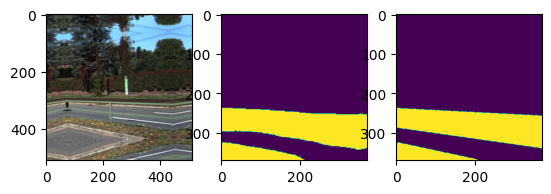

In [15]:
dat = train_dataset[10]
x = dat['image']
y = central_crop(dat['mask'].unsqueeze(dim=0), 370)[0]

device = 'cuda:0'
model = UNet(n_channels=3, n_classes=1).to(device)
model.load_state_dict(torch.load('checkpoint_240.pt'))
model = model.eval()

logits = F.adaptive_max_pool2d(model(torch.tensor(x).unsqueeze(dim=0).to(device)), 370).detach().cpu()[0]
pred = (F.sigmoid(logits) > 0.5)
print(pred.shape)

plt.subplot(1, 3, 1)
plt.imshow(x.permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(pred.permute(1, 2, 0))
plt.subplot(1, 3, 3)
plt.imshow(y.permute(1, 2, 0))

In [19]:
model.load_state_dict(torch.load(f'checkpoint_240.pt'))
model = model.eval()
print(test(model, 0.5, 'test'))
print(test(model, 0.5, 'train'))

/tmp/ipykernel_1789134/3298272329.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = F.adaptive_max_pool2d(model(torch.tensor(x).to(device)).cpu(), output_size=(370,370))[0]


0.7514998424426843
0.8732240806610678


In [48]:
import torchvision


class VGG16Block1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
    def forward(self, x):
        return self.net(x)
    

class VGG16Block2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
    def forward(self, x):
        return self.net(x)
    

class UpVGG16(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv((in_channels // 2 + in_channels), out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
    
class UpOut(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, 8, kernel_size=2, stride=2)
        self.conv = DoubleConv(8, 1)

    def forward(self, x):
        x = self.up(x)
        return self.conv(x)



class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.down1 = VGG16Block1(3, 64)
        self.down2 = VGG16Block1(64, 128)
        self.down3 = VGG16Block2(128, 256)
        self.down4 = VGG16Block2(256, 512)
        self.down5 = VGG16Block2(512, 512)
        
        self.up1 = UpVGG16(512, 256)
        self.up2 = UpVGG16(256, 128)
        self.up3 = UpVGG16(128, 64)
        self.up4 = UpVGG16(64, 32)
        self.outc = UpOut(32, 1)
        
        vgg16 = torchvision.models.vgg16_bn(pretrained=True)
        for i in range(7):
            self.down1.net[i].load_state_dict(vgg16.features[i].state_dict())
        for i in range(7):
            self.down2.net[i].load_state_dict(vgg16.features[i + 7].state_dict())
        for i in range(10):
            self.down3.net[i].load_state_dict(vgg16.features[i + 7 + 7].state_dict())
        for i in range(10):
            self.down4.net[i].load_state_dict(vgg16.features[i + 7 + 7 + 10].state_dict())
        for i in range(10):
            self.down5.net[i].load_state_dict(vgg16.features[i + 7 + 7 + 10 + 10].state_dict())
        
    def forward(self, x):
        # with torch.no_grad():
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [49]:
SegNet()(torch.zeros(1, 3, 256, 256)).shape

torch.Size([1, 1, 256, 256])

In [54]:
from torch.optim import Adam
from tqdm import trange   
from torch.utils.data import DataLoader


device = 'cuda:0'
model = SegNet().to(device).train()
opt = Adam(model.parameters())
tot = len(X_train)
losses = []
ious = []

for iepoch in trange(300):
    for g in opt.param_groups:
        g['lr'] = 0.001 * (1 - iepoch / 300)

    epoch_loss = []
    for item in DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1):
        x = item['image'].to(device)
        y = item['mask'].to(device)
        batch_size = x.shape[0]
        
        logits = F.adaptive_max_pool2d(model(x), output_size=(370, 370)).reshape(batch_size, -1)
        y = central_crop(y, 370).reshape(batch_size, -1)
        #logits = model(x).view(batch_size, -1)
        #y = y.view(batch_size, -1)
        
        opt.zero_grad()
        loss = F.binary_cross_entropy_with_logits(
            logits.view(batch_size, -1),
            y.view(batch_size, -1), 
            pos_weight=torch.tensor(5),
        )

        
        loss.backward()
        opt.step()
        epoch_loss.append(loss.detach().cpu().numpy())
    losses.append(np.mean(epoch_loss))
    # ious.append(test(model))
    torch.save(model.state_dict(), f'segnet_checkpoint_{iepoch}.pt')
    print(losses[-1])


  0%|▍                                                                                                                                   | 1/300 [00:12<59:49, 12.01s/it]

0.9124856


  1%|▉                                                                                                                                   | 2/300 [00:23<59:26, 11.97s/it]

0.78798693


  1%|█▎                                                                                                                                  | 3/300 [00:35<59:19, 11.99s/it]

0.7736354


  1%|█▊                                                                                                                                  | 4/300 [00:47<59:13, 12.01s/it]

0.74838835


  2%|██▏                                                                                                                                 | 5/300 [00:59<58:52, 11.97s/it]

0.7365308


  2%|██▋                                                                                                                                 | 6/300 [01:11<58:49, 12.01s/it]

0.7302466


  2%|███                                                                                                                                 | 7/300 [01:24<58:44, 12.03s/it]

0.7121226


  3%|███▌                                                                                                                                | 8/300 [01:36<58:43, 12.07s/it]

0.7102917


  3%|███▉                                                                                                                                | 9/300 [01:48<58:29, 12.06s/it]

0.70700383


  3%|████▎                                                                                                                              | 10/300 [02:00<58:15, 12.05s/it]

0.7005698


  4%|████▊                                                                                                                              | 11/300 [02:12<58:02, 12.05s/it]

0.69623893


  4%|█████▏                                                                                                                             | 12/300 [02:24<57:41, 12.02s/it]

0.693217


  4%|█████▋                                                                                                                             | 13/300 [02:36<57:16, 11.97s/it]

0.70004654


  5%|██████                                                                                                                             | 14/300 [02:48<57:10, 11.99s/it]

0.6911387


  5%|██████▌                                                                                                                            | 15/300 [03:00<56:50, 11.97s/it]

0.67361826


  5%|██████▉                                                                                                                            | 16/300 [03:12<56:38, 11.97s/it]

0.67831427


  6%|███████▍                                                                                                                           | 17/300 [03:23<56:22, 11.95s/it]

0.6733411


  6%|███████▊                                                                                                                           | 18/300 [03:35<56:15, 11.97s/it]

0.6861929


  6%|████████▎                                                                                                                          | 19/300 [03:47<56:04, 11.97s/it]

0.68116957


  7%|████████▋                                                                                                                          | 20/300 [03:59<55:51, 11.97s/it]

0.67261976


  7%|█████████▏                                                                                                                         | 21/300 [04:11<55:40, 11.97s/it]

0.66363406


  7%|█████████▌                                                                                                                         | 22/300 [04:23<55:26, 11.97s/it]

0.67623436


  8%|██████████                                                                                                                         | 23/300 [04:35<55:20, 11.99s/it]

0.6705684


  8%|██████████▍                                                                                                                        | 24/300 [04:47<55:09, 11.99s/it]

0.6656865


  8%|██████████▉                                                                                                                        | 25/300 [04:59<54:52, 11.97s/it]

0.65162057


  9%|███████████▎                                                                                                                       | 26/300 [05:11<54:46, 11.99s/it]

0.65138257


  9%|███████████▊                                                                                                                       | 27/300 [05:23<54:34, 11.99s/it]

0.65143406


  9%|████████████▏                                                                                                                      | 28/300 [05:35<54:17, 11.98s/it]

0.64823693


 10%|████████████▋                                                                                                                      | 29/300 [05:47<54:02, 11.96s/it]

0.65609175


 10%|█████████████                                                                                                                      | 30/300 [05:59<53:44, 11.94s/it]

0.64531887


 10%|█████████████▌                                                                                                                     | 31/300 [06:11<53:32, 11.94s/it]

0.63873273


 11%|█████████████▉                                                                                                                     | 32/300 [06:23<53:17, 11.93s/it]

0.63998544


 11%|██████████████▍                                                                                                                    | 33/300 [06:35<53:08, 11.94s/it]

0.64420545


 11%|██████████████▊                                                                                                                    | 34/300 [06:47<52:52, 11.93s/it]

0.64747405


 12%|███████████████▎                                                                                                                   | 35/300 [06:59<52:39, 11.92s/it]

0.6413307


 12%|███████████████▋                                                                                                                   | 36/300 [07:11<52:31, 11.94s/it]

0.6349983


 12%|████████████████▏                                                                                                                  | 37/300 [07:23<52:17, 11.93s/it]

0.63588554


 13%|████████████████▌                                                                                                                  | 38/300 [07:35<52:14, 11.97s/it]

0.63892156


 13%|█████████████████                                                                                                                  | 39/300 [07:47<52:00, 11.96s/it]

0.62659454


 13%|█████████████████▍                                                                                                                 | 40/300 [07:59<51:44, 11.94s/it]

0.6266614


 14%|█████████████████▉                                                                                                                 | 41/300 [08:10<51:32, 11.94s/it]

0.6215703


 14%|██████████████████▎                                                                                                                | 42/300 [08:22<51:29, 11.97s/it]

0.6227616


 14%|██████████████████▊                                                                                                                | 43/300 [08:35<51:20, 11.98s/it]

0.62493813


 15%|███████████████████▏                                                                                                               | 44/300 [08:46<51:04, 11.97s/it]

0.6250806


 15%|███████████████████▋                                                                                                               | 45/300 [08:58<50:55, 11.98s/it]

0.6233531


 15%|████████████████████                                                                                                               | 46/300 [09:10<50:45, 11.99s/it]

0.6221


 16%|████████████████████▌                                                                                                              | 47/300 [09:22<50:28, 11.97s/it]

0.61959183


 16%|████████████████████▉                                                                                                              | 48/300 [09:34<50:12, 11.95s/it]

0.6195464


 16%|█████████████████████▍                                                                                                             | 49/300 [09:46<49:55, 11.93s/it]

0.6158594


 17%|█████████████████████▊                                                                                                             | 50/300 [09:58<49:44, 11.94s/it]

0.6173007


 17%|██████████████████████▎                                                                                                            | 51/300 [10:10<49:27, 11.92s/it]

0.61893666


 17%|██████████████████████▋                                                                                                            | 52/300 [10:22<49:19, 11.93s/it]

0.61628634


 18%|███████████████████████▏                                                                                                           | 53/300 [10:34<49:09, 11.94s/it]

0.6109688


 18%|███████████████████████▌                                                                                                           | 54/300 [10:46<49:08, 11.98s/it]

0.6284811


 18%|████████████████████████                                                                                                           | 55/300 [10:58<48:55, 11.98s/it]

0.67180675


 19%|████████████████████████▍                                                                                                          | 56/300 [11:10<48:40, 11.97s/it]

0.65282947


 19%|████████████████████████▉                                                                                                          | 57/300 [11:22<48:29, 11.97s/it]

0.6444833


 19%|█████████████████████████▎                                                                                                         | 58/300 [11:34<48:19, 11.98s/it]

0.63000476


 20%|█████████████████████████▊                                                                                                         | 59/300 [11:46<48:01, 11.96s/it]

0.6215055


 20%|██████████████████████████▏                                                                                                        | 60/300 [11:58<47:49, 11.96s/it]

0.61510307


 20%|██████████████████████████▋                                                                                                        | 61/300 [12:10<47:33, 11.94s/it]

0.6185349


 21%|███████████████████████████                                                                                                        | 62/300 [12:22<47:17, 11.92s/it]

0.6185727


 21%|███████████████████████████▌                                                                                                       | 63/300 [12:33<47:02, 11.91s/it]

0.6174112


 21%|███████████████████████████▉                                                                                                       | 64/300 [12:45<46:50, 11.91s/it]

0.6129378


 22%|████████████████████████████▍                                                                                                      | 65/300 [12:57<46:41, 11.92s/it]

0.617834


 22%|████████████████████████████▊                                                                                                      | 66/300 [13:09<46:28, 11.92s/it]

0.6108676


 22%|█████████████████████████████▎                                                                                                     | 67/300 [13:21<46:13, 11.90s/it]

0.6074803


 23%|█████████████████████████████▋                                                                                                     | 68/300 [13:33<46:08, 11.93s/it]

0.60751164


 23%|██████████████████████████████▏                                                                                                    | 69/300 [13:45<45:54, 11.93s/it]

0.6060522


 23%|██████████████████████████████▌                                                                                                    | 70/300 [13:57<45:47, 11.95s/it]

0.60212886


 24%|███████████████████████████████                                                                                                    | 71/300 [14:09<45:32, 11.93s/it]

0.60821164


 24%|███████████████████████████████▍                                                                                                   | 72/300 [14:21<45:13, 11.90s/it]

0.60189515


 24%|███████████████████████████████▉                                                                                                   | 73/300 [14:33<44:58, 11.89s/it]

0.60314393


 25%|████████████████████████████████▎                                                                                                  | 74/300 [14:45<44:54, 11.92s/it]

0.6054025


 25%|████████████████████████████████▊                                                                                                  | 75/300 [14:57<44:45, 11.93s/it]

0.60365164


 25%|█████████████████████████████████▏                                                                                                 | 76/300 [15:08<44:29, 11.92s/it]

0.6021081


 26%|█████████████████████████████████▌                                                                                                 | 77/300 [15:20<44:22, 11.94s/it]

0.60028833


 26%|██████████████████████████████████                                                                                                 | 78/300 [15:32<44:13, 11.95s/it]

0.5979526


 26%|██████████████████████████████████▍                                                                                                | 79/300 [15:44<44:00, 11.95s/it]

0.59785557


 27%|██████████████████████████████████▉                                                                                                | 80/300 [15:56<43:48, 11.95s/it]

0.59759766


 27%|███████████████████████████████████▎                                                                                               | 81/300 [16:08<43:34, 11.94s/it]

0.60277295


 27%|███████████████████████████████████▊                                                                                               | 82/300 [16:20<43:21, 11.93s/it]

0.60039693


 28%|████████████████████████████████████▏                                                                                              | 83/300 [16:32<43:00, 11.89s/it]

0.5963769


 28%|████████████████████████████████████▋                                                                                              | 84/300 [16:44<42:46, 11.88s/it]

0.5994375


 28%|█████████████████████████████████████                                                                                              | 85/300 [16:56<42:45, 11.93s/it]

0.6131953


 29%|█████████████████████████████████████▌                                                                                             | 86/300 [17:08<42:29, 11.91s/it]

0.62606174


 29%|█████████████████████████████████████▉                                                                                             | 87/300 [17:20<42:15, 11.91s/it]

0.61459935


 29%|██████████████████████████████████████▍                                                                                            | 88/300 [17:31<42:04, 11.91s/it]

0.6035485


 30%|██████████████████████████████████████▊                                                                                            | 89/300 [17:43<41:46, 11.88s/it]

0.61033577


 30%|███████████████████████████████████████▎                                                                                           | 90/300 [17:55<41:35, 11.89s/it]

0.6044843


 30%|███████████████████████████████████████▋                                                                                           | 91/300 [18:07<41:26, 11.90s/it]

0.5985182


 31%|████████████████████████████████████████▏                                                                                          | 92/300 [18:19<41:09, 11.87s/it]

0.595641


 31%|████████████████████████████████████████▌                                                                                          | 93/300 [18:31<40:59, 11.88s/it]

0.5946202


 31%|█████████████████████████████████████████                                                                                          | 94/300 [18:43<40:44, 11.87s/it]

0.5937701


 32%|█████████████████████████████████████████▍                                                                                         | 95/300 [18:54<40:30, 11.86s/it]

0.5944399


 32%|█████████████████████████████████████████▉                                                                                         | 96/300 [19:06<40:16, 11.85s/it]

0.5938102


 32%|██████████████████████████████████████████▎                                                                                        | 97/300 [19:18<40:06, 11.86s/it]

0.59100646


 33%|██████████████████████████████████████████▊                                                                                        | 98/300 [19:30<39:51, 11.84s/it]

0.5915681


 33%|███████████████████████████████████████████▏                                                                                       | 99/300 [19:42<39:39, 11.84s/it]

0.59926414


 33%|███████████████████████████████████████████▎                                                                                      | 100/300 [19:54<39:22, 11.81s/it]

0.5945455


 34%|███████████████████████████████████████████▊                                                                                      | 101/300 [20:05<39:07, 11.80s/it]

0.5917759


 34%|████████████████████████████████████████████▏                                                                                     | 102/300 [20:17<39:05, 11.84s/it]

0.5893052


 34%|████████████████████████████████████████████▋                                                                                     | 103/300 [20:29<38:52, 11.84s/it]

0.5922547


 35%|█████████████████████████████████████████████                                                                                     | 104/300 [20:41<38:39, 11.84s/it]

0.58977824


 35%|█████████████████████████████████████████████▌                                                                                    | 105/300 [20:53<38:28, 11.84s/it]

0.5908134


 35%|█████████████████████████████████████████████▉                                                                                    | 106/300 [21:05<38:17, 11.84s/it]

0.5892411


 36%|██████████████████████████████████████████████▎                                                                                   | 107/300 [21:17<38:08, 11.86s/it]

0.5903205


 36%|██████████████████████████████████████████████▊                                                                                   | 108/300 [21:28<37:53, 11.84s/it]

0.5906923


 36%|███████████████████████████████████████████████▏                                                                                  | 109/300 [21:40<37:45, 11.86s/it]

0.5888113


 37%|███████████████████████████████████████████████▋                                                                                  | 110/300 [21:52<37:34, 11.86s/it]

0.5888623


 37%|████████████████████████████████████████████████                                                                                  | 111/300 [22:04<37:22, 11.86s/it]

0.5899135


 37%|████████████████████████████████████████████████▌                                                                                 | 112/300 [22:16<37:15, 11.89s/it]

0.5886692


 38%|████████████████████████████████████████████████▉                                                                                 | 113/300 [22:28<37:00, 11.87s/it]

0.5861139


 38%|█████████████████████████████████████████████████▍                                                                                | 114/300 [22:40<36:45, 11.86s/it]

0.5858674


 38%|█████████████████████████████████████████████████▊                                                                                | 115/300 [22:51<36:32, 11.85s/it]

0.5870907


 39%|██████████████████████████████████████████████████▎                                                                               | 116/300 [23:03<36:31, 11.91s/it]

0.5857743


 39%|██████████████████████████████████████████████████▋                                                                               | 117/300 [23:15<36:17, 11.90s/it]

0.585043


 39%|███████████████████████████████████████████████████▏                                                                              | 118/300 [23:27<36:03, 11.89s/it]

0.58523625


 40%|███████████████████████████████████████████████████▌                                                                              | 119/300 [23:39<35:48, 11.87s/it]

0.58572584


 40%|████████████████████████████████████████████████████                                                                              | 120/300 [23:51<35:39, 11.88s/it]

0.58826977


 40%|████████████████████████████████████████████████████▍                                                                             | 121/300 [24:03<35:33, 11.92s/it]

0.5889413


 41%|████████████████████████████████████████████████████▊                                                                             | 122/300 [24:15<35:17, 11.90s/it]

0.58493274


 41%|█████████████████████████████████████████████████████▎                                                                            | 123/300 [24:27<35:01, 11.87s/it]

0.58568954


 41%|█████████████████████████████████████████████████████▋                                                                            | 124/300 [24:39<34:51, 11.89s/it]

0.5817157


 42%|██████████████████████████████████████████████████████▏                                                                           | 125/300 [24:50<34:39, 11.88s/it]

0.5835707


 42%|██████████████████████████████████████████████████████▌                                                                           | 126/300 [25:02<34:29, 11.89s/it]

0.5834971


 42%|███████████████████████████████████████████████████████                                                                           | 127/300 [25:14<34:17, 11.89s/it]

0.5856892


 43%|███████████████████████████████████████████████████████▍                                                                          | 128/300 [25:26<34:07, 11.90s/it]

0.58380616


 43%|███████████████████████████████████████████████████████▉                                                                          | 129/300 [25:38<33:53, 11.89s/it]

0.5840076


 43%|████████████████████████████████████████████████████████▎                                                                         | 130/300 [25:50<33:42, 11.90s/it]

0.58090526


 44%|████████████████████████████████████████████████████████▊                                                                         | 131/300 [26:02<33:29, 11.89s/it]

0.58040893


 44%|█████████████████████████████████████████████████████████▏                                                                        | 132/300 [26:14<33:21, 11.91s/it]

0.5827464


 44%|█████████████████████████████████████████████████████████▋                                                                        | 133/300 [26:26<33:11, 11.93s/it]

0.58289224


 45%|██████████████████████████████████████████████████████████                                                                        | 134/300 [26:38<32:55, 11.90s/it]

0.58174294


 45%|██████████████████████████████████████████████████████████▌                                                                       | 135/300 [26:49<32:43, 11.90s/it]

0.57859796


 45%|██████████████████████████████████████████████████████████▉                                                                       | 136/300 [27:01<32:33, 11.91s/it]

0.58246523


 46%|███████████████████████████████████████████████████████████▎                                                                      | 137/300 [27:13<32:18, 11.89s/it]

0.58641076


 46%|███████████████████████████████████████████████████████████▊                                                                      | 138/300 [27:25<32:06, 11.89s/it]

0.5918332


 46%|████████████████████████████████████████████████████████████▏                                                                     | 139/300 [27:37<31:57, 11.91s/it]

0.58670765


 47%|████████████████████████████████████████████████████████████▋                                                                     | 140/300 [27:49<31:46, 11.92s/it]

0.58057004


 47%|█████████████████████████████████████████████████████████████                                                                     | 141/300 [28:01<31:29, 11.88s/it]

0.5797756


 47%|█████████████████████████████████████████████████████████████▌                                                                    | 142/300 [28:13<31:17, 11.88s/it]

0.5798222


 48%|█████████████████████████████████████████████████████████████▉                                                                    | 143/300 [28:25<31:08, 11.90s/it]

0.57969224


 48%|██████████████████████████████████████████████████████████████▍                                                                   | 144/300 [28:37<30:56, 11.90s/it]

0.5815827


 48%|██████████████████████████████████████████████████████████████▊                                                                   | 145/300 [28:48<30:42, 11.89s/it]

0.57908314


 49%|███████████████████████████████████████████████████████████████▎                                                                  | 146/300 [29:00<30:28, 11.88s/it]

0.5778468


 49%|███████████████████████████████████████████████████████████████▋                                                                  | 147/300 [29:12<30:19, 11.89s/it]

0.5802211


 49%|████████████████████████████████████████████████████████████████▏                                                                 | 148/300 [29:24<30:04, 11.87s/it]

0.576012


 50%|████████████████████████████████████████████████████████████████▌                                                                 | 149/300 [29:36<29:53, 11.88s/it]

0.5769965


 50%|█████████████████████████████████████████████████████████████████                                                                 | 150/300 [29:48<29:36, 11.84s/it]

0.5780215


 50%|█████████████████████████████████████████████████████████████████▍                                                                | 151/300 [30:00<29:28, 11.87s/it]

0.5766705


 51%|█████████████████████████████████████████████████████████████████▊                                                                | 152/300 [30:12<29:21, 11.90s/it]

0.5763495


 51%|██████████████████████████████████████████████████████████████████▎                                                               | 153/300 [30:23<29:07, 11.89s/it]

0.57556546


 51%|██████████████████████████████████████████████████████████████████▋                                                               | 154/300 [30:35<28:55, 11.89s/it]

0.57732767


 52%|███████████████████████████████████████████████████████████████████▏                                                              | 155/300 [30:47<28:48, 11.92s/it]

0.57837653


 52%|███████████████████████████████████████████████████████████████████▌                                                              | 156/300 [30:59<28:38, 11.93s/it]

0.5767474


 52%|████████████████████████████████████████████████████████████████████                                                              | 157/300 [31:11<28:20, 11.89s/it]

0.577579


 53%|████████████████████████████████████████████████████████████████████▍                                                             | 158/300 [31:23<28:11, 11.91s/it]

0.57666904


 53%|████████████████████████████████████████████████████████████████████▉                                                             | 159/300 [31:35<27:59, 11.91s/it]

0.57527095


 53%|█████████████████████████████████████████████████████████████████████▎                                                            | 160/300 [31:47<27:45, 11.89s/it]

0.57603174


 54%|█████████████████████████████████████████████████████████████████████▊                                                            | 161/300 [31:59<27:34, 11.90s/it]

0.57459515


 54%|██████████████████████████████████████████████████████████████████████▏                                                           | 162/300 [32:11<27:24, 11.91s/it]

0.5761702


 54%|██████████████████████████████████████████████████████████████████████▋                                                           | 163/300 [32:23<27:11, 11.91s/it]

0.5766889


 55%|███████████████████████████████████████████████████████████████████████                                                           | 164/300 [32:34<26:58, 11.90s/it]

0.57658106


 55%|███████████████████████████████████████████████████████████████████████▌                                                          | 165/300 [32:46<26:46, 11.90s/it]

0.5775229


 55%|███████████████████████████████████████████████████████████████████████▉                                                          | 166/300 [32:58<26:30, 11.87s/it]

0.5784825


 56%|████████████████████████████████████████████████████████████████████████▎                                                         | 167/300 [33:10<26:17, 11.86s/it]

0.5774072


 56%|████████████████████████████████████████████████████████████████████████▊                                                         | 168/300 [33:22<26:03, 11.85s/it]

0.57778096


 56%|█████████████████████████████████████████████████████████████████████████▏                                                        | 169/300 [33:34<25:52, 11.85s/it]

0.5752


 57%|█████████████████████████████████████████████████████████████████████████▋                                                        | 170/300 [33:46<25:45, 11.89s/it]

0.5742752


 57%|██████████████████████████████████████████████████████████████████████████                                                        | 171/300 [33:58<25:34, 11.90s/it]

0.5755276


 57%|██████████████████████████████████████████████████████████████████████████▌                                                       | 172/300 [34:09<25:18, 11.86s/it]

0.57434374


 58%|██████████████████████████████████████████████████████████████████████████▉                                                       | 173/300 [34:21<25:06, 11.86s/it]

0.5732014


 58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 174/300 [34:33<24:55, 11.87s/it]

0.5750298


 58%|███████████████████████████████████████████████████████████████████████████▊                                                      | 175/300 [34:45<24:41, 11.85s/it]

0.5743783


 59%|████████████████████████████████████████████████████████████████████████████▎                                                     | 176/300 [34:57<24:30, 11.86s/it]

0.573479


 59%|████████████████████████████████████████████████████████████████████████████▋                                                     | 177/300 [35:09<24:23, 11.90s/it]

0.5747068


 59%|█████████████████████████████████████████████████████████████████████████████▏                                                    | 178/300 [35:21<24:09, 11.88s/it]

0.5770184


 60%|█████████████████████████████████████████████████████████████████████████████▌                                                    | 179/300 [35:32<23:57, 11.88s/it]

0.5736421


 60%|██████████████████████████████████████████████████████████████████████████████                                                    | 180/300 [35:44<23:44, 11.87s/it]

0.57387906


 60%|██████████████████████████████████████████████████████████████████████████████▍                                                   | 181/300 [35:56<23:30, 11.86s/it]

0.57483494


 61%|██████████████████████████████████████████████████████████████████████████████▊                                                   | 182/300 [36:08<23:24, 11.90s/it]

0.5733505


 61%|███████████████████████████████████████████████████████████████████████████████▎                                                  | 183/300 [36:20<23:10, 11.88s/it]

0.5731401


 61%|███████████████████████████████████████████████████████████████████████████████▋                                                  | 184/300 [36:32<22:56, 11.87s/it]

0.57123464


 62%|████████████████████████████████████████████████████████████████████████████████▏                                                 | 185/300 [36:44<22:42, 11.85s/it]

0.5742858


 62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 186/300 [36:56<22:32, 11.86s/it]

0.57458675


 62%|█████████████████████████████████████████████████████████████████████████████████                                                 | 187/300 [37:07<22:21, 11.87s/it]

0.5716343


 63%|█████████████████████████████████████████████████████████████████████████████████▍                                                | 188/300 [37:19<22:07, 11.85s/it]

0.5731769


 63%|█████████████████████████████████████████████████████████████████████████████████▉                                                | 189/300 [37:31<21:53, 11.84s/it]

0.571075


 63%|██████████████████████████████████████████████████████████████████████████████████▎                                               | 190/300 [37:43<21:45, 11.87s/it]

0.57507515


 64%|██████████████████████████████████████████████████████████████████████████████████▊                                               | 191/300 [37:55<21:32, 11.85s/it]

0.5780915


 64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 192/300 [38:07<21:21, 11.87s/it]

0.5775271


 64%|███████████████████████████████████████████████████████████████████████████████████▋                                              | 193/300 [38:19<21:09, 11.86s/it]

0.5752485


 65%|████████████████████████████████████████████████████████████████████████████████████                                              | 194/300 [38:31<21:01, 11.90s/it]

0.5732614


 65%|████████████████████████████████████████████████████████████████████████████████████▌                                             | 195/300 [38:42<20:46, 11.87s/it]

0.57247573


 65%|████████████████████████████████████████████████████████████████████████████████████▉                                             | 196/300 [38:54<20:34, 11.87s/it]

0.5702249


 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                            | 197/300 [39:06<20:22, 11.87s/it]

0.57327306


 66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 198/300 [39:18<20:09, 11.86s/it]

0.5697705


 66%|██████████████████████████████████████████████████████████████████████████████████████▏                                           | 199/300 [39:30<20:03, 11.91s/it]

0.56933856


 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                           | 200/300 [39:42<19:50, 11.91s/it]

0.5701064


 67%|███████████████████████████████████████████████████████████████████████████████████████                                           | 201/300 [39:54<19:40, 11.93s/it]

0.5714524


 67%|███████████████████████████████████████████████████████████████████████████████████████▌                                          | 202/300 [40:06<19:26, 11.90s/it]

0.57043046


 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                          | 203/300 [40:17<19:10, 11.86s/it]

0.5687509


 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                         | 204/300 [40:29<19:01, 11.89s/it]

0.5724082


 68%|████████████████████████████████████████████████████████████████████████████████████████▊                                         | 205/300 [40:41<18:51, 11.91s/it]

0.57219344


 69%|█████████████████████████████████████████████████████████████████████████████████████████▎                                        | 206/300 [40:53<18:37, 11.89s/it]

0.5736545


 69%|█████████████████████████████████████████████████████████████████████████████████████████▋                                        | 207/300 [41:05<18:27, 11.91s/it]

0.57123744


 69%|██████████████████████████████████████████████████████████████████████████████████████████▏                                       | 208/300 [41:17<18:13, 11.89s/it]

0.5685703


 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                       | 209/300 [41:29<18:01, 11.88s/it]

0.5709485


 70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 210/300 [41:41<17:51, 11.90s/it]

0.5685891


 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                      | 211/300 [41:53<17:40, 11.92s/it]

0.569889


 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                      | 212/300 [42:05<17:27, 11.90s/it]

0.5683791


 71%|████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 213/300 [42:16<17:13, 11.88s/it]

0.5750133


 71%|████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 214/300 [42:28<17:02, 11.88s/it]

0.5850881


 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 215/300 [42:40<16:50, 11.89s/it]

0.5779676


 72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 216/300 [42:52<16:38, 11.89s/it]

0.5763854


 72%|██████████████████████████████████████████████████████████████████████████████████████████████                                    | 217/300 [43:04<16:26, 11.88s/it]

0.58286965


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 218/300 [43:16<16:13, 11.87s/it]

0.58753365


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 219/300 [43:28<16:02, 11.88s/it]

0.58043134


 73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 220/300 [43:40<15:49, 11.87s/it]

0.5769456


 74%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 221/300 [43:51<15:36, 11.85s/it]

0.57110596


 74%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 222/300 [44:03<15:24, 11.86s/it]

0.57516396


 74%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 223/300 [44:15<15:13, 11.86s/it]

0.57745904


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████                                 | 224/300 [44:27<15:01, 11.86s/it]

0.57466215


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 225/300 [44:39<14:49, 11.86s/it]

0.57086635


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 226/300 [44:51<14:37, 11.86s/it]

0.5724112


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 227/300 [45:03<14:25, 11.85s/it]

0.5685222


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 228/300 [45:14<14:11, 11.83s/it]

0.5689167


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 229/300 [45:26<14:00, 11.84s/it]

0.57134444


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 230/300 [45:38<13:47, 11.83s/it]

0.5693173


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████                              | 231/300 [45:50<13:37, 11.85s/it]

0.5690674


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 232/300 [46:02<13:24, 11.84s/it]

0.570407


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 233/300 [46:14<13:13, 11.84s/it]

0.56821895


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 234/300 [46:25<13:01, 11.84s/it]

0.5710553


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 235/300 [46:37<12:51, 11.87s/it]

0.56873024


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 236/300 [46:49<12:39, 11.86s/it]

0.568893


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 237/300 [47:01<12:27, 11.86s/it]

0.5673922


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 238/300 [47:13<12:15, 11.87s/it]

0.57057655


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 239/300 [47:25<12:04, 11.88s/it]

0.5683526


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 240/300 [47:37<11:53, 11.88s/it]

0.5692863


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 241/300 [47:48<11:39, 11.85s/it]

0.56729305


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 242/300 [48:00<11:27, 11.85s/it]

0.56509274


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 243/300 [48:12<11:16, 11.86s/it]

0.5676314


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 244/300 [48:24<11:03, 11.85s/it]

0.5674697


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 245/300 [48:36<10:51, 11.85s/it]

0.5680597


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 246/300 [48:48<10:38, 11.83s/it]

0.5649739


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 247/300 [49:00<10:26, 11.82s/it]

0.5682376


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 248/300 [49:11<10:15, 11.83s/it]

0.5662362


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 249/300 [49:23<10:06, 11.88s/it]

0.5753041


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 250/300 [49:35<09:56, 11.93s/it]

0.5730731


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 251/300 [49:47<09:43, 11.91s/it]

0.5722056


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 252/300 [49:59<09:31, 11.90s/it]

0.57088214


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 253/300 [50:11<09:19, 11.89s/it]

0.56820744


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 254/300 [50:23<09:07, 11.89s/it]

0.5663717


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 255/300 [50:35<08:53, 11.86s/it]

0.56913453


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 256/300 [50:47<08:41, 11.85s/it]

0.56625426


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 257/300 [50:58<08:29, 11.86s/it]

0.56518584


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 258/300 [51:10<08:18, 11.87s/it]

0.56595945


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 259/300 [51:22<08:06, 11.87s/it]

0.5653093


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 260/300 [51:34<07:56, 11.91s/it]

0.5660485


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 261/300 [51:46<07:44, 11.91s/it]

0.56645507


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 262/300 [51:58<07:30, 11.86s/it]

0.5669877


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 263/300 [52:10<07:18, 11.85s/it]

0.5664875


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 264/300 [52:22<07:07, 11.86s/it]

0.56757385


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 265/300 [52:33<06:54, 11.85s/it]

0.5682158


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 266/300 [52:45<06:44, 11.91s/it]

0.56748074


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 267/300 [52:57<06:32, 11.91s/it]

0.5656839


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 268/300 [53:09<06:19, 11.87s/it]

0.5686601


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 269/300 [53:21<06:07, 11.86s/it]

0.5636624


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 270/300 [53:33<05:56, 11.87s/it]

0.5663977


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 271/300 [53:45<05:45, 11.91s/it]

0.5664851


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 272/300 [53:57<05:32, 11.87s/it]

0.5641561


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 273/300 [54:09<05:21, 11.89s/it]

0.5657401


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 274/300 [54:20<05:08, 11.88s/it]

0.5645669


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 275/300 [54:32<04:57, 11.89s/it]

0.564228


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 276/300 [54:44<04:45, 11.89s/it]

0.56503344


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 277/300 [54:56<04:33, 11.87s/it]

0.5645525


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 278/300 [55:08<04:20, 11.85s/it]

0.5669635


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 279/300 [55:20<04:09, 11.90s/it]

0.5659642


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 280/300 [55:32<03:57, 11.86s/it]

0.5659594


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 281/300 [55:44<03:45, 11.87s/it]

0.56343496


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 282/300 [55:55<03:33, 11.86s/it]

0.56615114


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 283/300 [56:07<03:21, 11.84s/it]

0.56510293


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 284/300 [56:19<03:09, 11.84s/it]

0.56625336


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 285/300 [56:31<02:57, 11.83s/it]

0.56551355


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 286/300 [56:43<02:45, 11.83s/it]

0.5665449


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 287/300 [56:55<02:34, 11.86s/it]

0.56598765


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 288/300 [57:06<02:22, 11.87s/it]

0.56507355


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 289/300 [57:18<02:10, 11.88s/it]

0.5641705


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 290/300 [57:30<01:58, 11.89s/it]

0.5628833


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 291/300 [57:42<01:47, 11.89s/it]

0.56391025


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 292/300 [57:54<01:35, 11.89s/it]

0.5637641


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 293/300 [58:06<01:23, 11.86s/it]

0.5658504


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 294/300 [58:18<01:11, 11.86s/it]

0.56504565


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 295/300 [58:30<00:59, 11.89s/it]

0.5662178


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 296/300 [58:42<00:47, 11.90s/it]

0.56540143


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 297/300 [58:54<00:35, 11.91s/it]

0.5634268


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 298/300 [59:05<00:23, 11.87s/it]

0.5646486


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 299/300 [59:17<00:11, 11.88s/it]

0.5638096


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [59:29<00:00, 11.90s/it]

0.56344825


torch.Size([1, 370, 370])


/tmp/ipykernel_1789134/3197881594.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = F.adaptive_max_pool2d(model(torch.tensor(x).unsqueeze(dim=0).to(device)), 370).detach().cpu()[0]


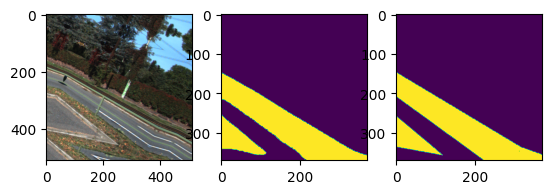

In [56]:
dat = train_dataset[10]
x = dat['image']
y = central_crop(dat['mask'].unsqueeze(dim=0), 370)[0]

device = 'cuda:0'
model = SegNet().to(device)
model.load_state_dict(torch.load('segnet_checkpoint_299.pt'))
model = model.eval()

logits = F.adaptive_max_pool2d(model(torch.tensor(x).unsqueeze(dim=0).to(device)), 370).detach().cpu()[0]
pred = (F.sigmoid(logits) > 0.5)
print(pred.shape)

plt.subplot(1, 3, 1)
plt.imshow(x.permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(pred.permute(1, 2, 0))
plt.subplot(1, 3, 3)
plt.imshow(y.permute(1, 2, 0))

In [57]:
model.load_state_dict(torch.load(f'segnet_checkpoint_299.pt'))
model = model.eval()
print(test(model, 0.5, 'test'))
print(test(model, 0.5, 'train'))

/tmp/ipykernel_1789134/3298272329.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = F.adaptive_max_pool2d(model(torch.tensor(x).to(device)).cpu(), output_size=(370,370))[0]


0.777151175864426
0.9030836556258819
